In [3]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

In [33]:
def random_walk(start, steps, noise_scale=1.0):
    poss = [start]
    for i in range(steps):
        poss.append(
            numpyro.sample(
                f"step_{i}", dist.Normal(poss[-1], noise_scale)
            ) + jnp.array([0.5,0.0])
        )
    return poss

In [34]:
def model(end_pos):
    start = numpyro.sample("start", dist.Normal(jnp.array([0.0, 0.0]), 10.0))
    poss = numpyro.sample("walk", random_walk(start, 10))
    numpyro.sample("end", dist.Normal(poss[-1], 0.2), obs=end_pos)

In [35]:
key = jr.key(1729)

mcmc = MCMC(NUTS(model), num_warmup=1000, num_samples=2000)
mcmc.run(key, end_pos=jnp.array([10.0,10.0]))
samples = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:05<00:00, 519.21it/s, 31 steps of size 1.75e-01. acc. prob=0.86] 


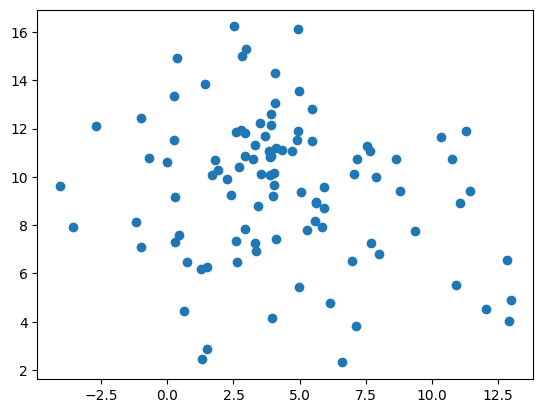

In [36]:
n = 100
plt.scatter(samples["start"][:n,0],samples["start"][:n,1])